In [1]:
import tensorflow as tf
import keras
print(keras.__version__)
import pydot
from keras import backend as K
from numba import cuda
import gc
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model
from sklearn.metrics import roc_curve, auc
import matplotlib
from keras.models import Sequential, Model, load_model
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score
from keras.applications.densenet import DenseNet121
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,confusion_matrix
import pandas as pd
import numpy as np
from time import time
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras import optimizers
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


2.2.4


#### Data preprocessing

All of the images were sorted into their respective directory folders manually using windows explorer search and drag and drop function.

### Built model

In [2]:
classifier = Sequential()

# First convulutional layer
classifier.add(Convolution2D(32, 3, 3, input_shape = (224, 224, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
classifier.add(Dropout(0.2))

# Second convolutional layer
classifier.add(Convolution2D(64, 3, 3))
classifier.add(Activation("relu"))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
classifier.add(Dropout(0.2))

#Third convolutional layer
classifier.add(Convolution2D(128,3, 3))
classifier.add(Activation("relu"))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
classifier.add(Dropout(0.2))

#Fourth convulutional layer
classifier.add(Convolution2D(256, 3, 3))
classifier.add(Activation("relu"))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
classifier.add(Dropout(0.2))


#Flattening, full connection and output = 1 for binary classification
classifier.add(Flatten())
classifier.add(Dense(output_dim = 512, activation = 'relu'))
classifier.add(Dropout(0.2))
classifier.add(Dense(output_dim = 1, activation = 'sigmoid'))



# Compile CNN
d = optimizers.Adam(lr=0.001)
classifier.compile(optimizer = d, loss = 'binary_crossentropy', metrics = ['accuracy'])


# initiate early stopping if no improvement on validation accuracy
earlyStopping = EarlyStopping(monitor='val_acc', patience = 10, min_delta=0.01,
                           mode='max', 
                           verbose=1)
#save best model
model_save = ModelCheckpoint('weights.scratch.hdf5', save_best_only=True, monitor='val_acc', mode='max')

#reduce learning rate if no change in validation loss
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=7, verbose=1, epsilon=1e-4, mode='min')



In [7]:
classifier.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
activation_1 (Activation)    (None, 109, 109, 64)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 54, 54, 64)        0         
__________

In [2]:
#Assign model parameters
num_of_valid_samples = 659
num_of_train_samples = 9710
batch_size= 64

#normalize image data
train_datagen_wrist = ImageDataGenerator(rescale = 1./255)
                
valid_datagen_wrist = ImageDataGenerator(rescale = 1./255)


#set training and validation path
training_set_wrist = train_datagen_wrist.flow_from_directory('C:/Users/arham/Downloads/sorted_train/wrist',
                                                                 target_size = (224, 224),
                                                                 batch_size = batch_size,
                                                                 class_mode = 'binary',classes=['negative', 'positive'])
 
valid_set_wrist = valid_datagen_wrist.flow_from_directory('C:/Users/arham/Downloads/sorted_valid/wrist',
                                            target_size = (224, 224),
                                            batch_size = batch_size, class_mode = 'binary',shuffle=False,classes=['negative', 'positive'])




Found 9710 images belonging to 2 classes.
Found 659 images belonging to 2 classes.


In [4]:
#fit model
hist_wrist = classifier.fit_generator(
        training_set_wrist,
        steps_per_epoch=(num_of_train_samples // batch_size),
        nb_epoch=20,
        validation_data=valid_set_wrist,
        validation_steps=num_of_valid_samples//batch_size,callbacks=[earlyStopping,model_save,reduce_lr_loss])

Epoch 1/20
151/151 [==============================] - 48s 320ms/step - loss: 0.6702 - acc: 0.6020 - val_loss: 0.6633 - val_acc: 0.6062
Epoch 2/20
151/151 [==============================] - 35s 233ms/step - loss: 0.6250 - acc: 0.6457 - val_loss: 0.6266 - val_acc: 0.6319
Epoch 3/20
151/151 [==============================] - 36s 238ms/step - loss: 0.5905 - acc: 0.6839 - val_loss: 0.6107 - val_acc: 0.6689
Epoch 4/20
151/151 [==============================] - 41s 272ms/step - loss: 0.5463 - acc: 0.7180 - val_loss: 0.5533 - val_acc: 0.7059
Epoch 5/20
151/151 [==============================] - 44s 289ms/step - loss: 0.5113 - acc: 0.7444 - val_loss: 0.5481 - val_acc: 0.7261
Epoch 6/20
151/151 [==============================] - 45s 298ms/step - loss: 0.4837 - acc: 0.7593 - val_loss: 0.5872 - val_acc: 0.6874
Epoch 7/20
151/151 [==============================] - 34s 227ms/step - loss: 0.4400 - acc: 0.7912 - val_loss: 0.6034 - val_acc: 0.6807
Epoch 8/20
151/151 [==============================] - 3

### Pre-trained model

In [2]:
#Assign model parameters
num_of_valid_samples2 = 659
num_of_train_samples2 = 9710
batch_size2= 16

#normalize image data
train_datagen_wrist = ImageDataGenerator(rescale = 1./255)
                
valid_datagen_wrist = ImageDataGenerator(rescale = 1./255)


#set training and validation path
training_set_wrist = train_datagen_wrist.flow_from_directory('C:/Users/arham/Downloads/sorted_train/wrist',
                                                                 target_size = (224, 224),
                                                                 batch_size = batch_size2,
                                                                 class_mode = 'binary',classes=['negative', 'positive'])
 
valid_set_wrist = valid_datagen_wrist.flow_from_directory('C:/Users/arham/Downloads/sorted_valid/wrist',
                                            target_size = (224, 224),
                                            batch_size = batch_size2, class_mode = 'binary',shuffle=False,classes=['negative', 'positive'])




Found 9710 images belonging to 2 classes.
Found 659 images belonging to 2 classes.


In [3]:
#import and assign our pre-trained model
densenet_model = DenseNet121(include_top=False, weights='imagenet',  input_shape=(224, 224, 3), pooling='avg')

In [6]:
#define our pre-trained model and add our last dense layer for binary output 1
def build_model():
    base_model = DenseNet121(input_shape=(224, 224,3),
                             weights='imagenet',
                             include_top=False,
                             pooling='avg')

    x = base_model.output
    predictions = Dense(1,activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model


In [7]:
classifier2 =  build_model()

In [8]:
classifier2.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# initiate early stopping if no improvement on validation accuracy
earlyStopping = EarlyStopping(monitor='val_acc', patience = 10, min_delta=0.01,
                           mode='max', 
                           verbose=1)

# reduce learning rate by factor of 0.2 if no significant changes 
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=7, verbose=1, epsilon=1e-4, mode='min')

In [9]:
#train model
hist_wrist2 = classifier2.fit_generator(
        training_set_wrist,
        steps_per_epoch=(num_of_train_samples2 // batch_size2),
        nb_epoch=20,
        validation_data=valid_set_wrist,
        validation_steps=num_of_valid_samples2//batch_size2,callbacks=[earlyStopping,reduce_lr_loss])

Epoch 1/20
606/606 [==============================] - 188s 310ms/step - loss: 0.6257 - acc: 0.6716 - val_loss: 0.6685 - val_acc: 0.6540
Epoch 2/20
606/606 [==============================] - 162s 268ms/step - loss: 0.5591 - acc: 0.7246 - val_loss: 0.5948 - val_acc: 0.6827
Epoch 3/20
606/606 [==============================] - 162s 268ms/step - loss: 0.5337 - acc: 0.7409 - val_loss: 0.5943 - val_acc: 0.6998
Epoch 4/20
606/606 [==============================] - 162s 268ms/step - loss: 0.5173 - acc: 0.7521 - val_loss: 0.5596 - val_acc: 0.7232
Epoch 5/20
606/606 [==============================] - 162s 268ms/step - loss: 0.5078 - acc: 0.7562 - val_loss: 2.3476 - val_acc: 0.4681
Epoch 6/20
606/606 [==============================] - 162s 268ms/step - loss: 0.4832 - acc: 0.7749 - val_loss: 0.4786 - val_acc: 0.7869
Epoch 7/20
606/606 [==============================] - 162s 268ms/step - loss: 0.4641 - acc: 0.7891 - val_loss: 0.5324 - val_acc: 0.7465
Epoch 8/20
606/606 [============================

### Evaluation

#### Built model

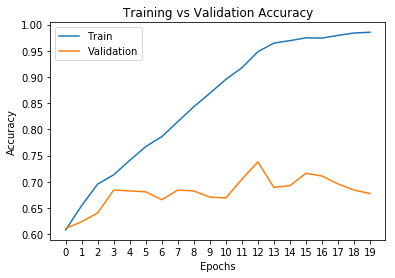

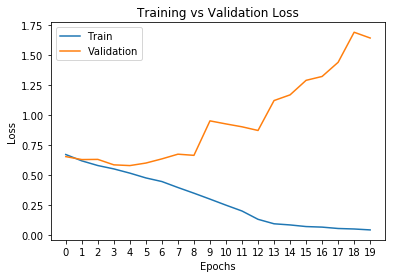

In [6]:
plt.figure(0)
plt.plot(hist_wrist.history['acc'],)
plt.plot(hist_wrist.history['val_acc'])
plt.xticks(np.arange(0, 20, 1))

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend(['Train','Validation'])
 
plt.figure(1)
plt.plot(hist_wrist.history['loss'])
plt.plot(hist_wrist.history['val_loss'])
plt.xticks(np.arange(0, 20, 1))

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend(['Train','Validation'])


 
plt.show()

Our peak validation accuracy is at 0.72  whereas our training accuracy peak is at 0.96

We can see that there is overfitting going on in our built model, where the training accuracy approaches 100%, and our validation accuracy appears to be on a decline. Similarily our validation loss increases as our model overfits.

In [7]:
#reset our validation to prevent order change
valid_set_wrist.reset()

#predictions on validation
Y_pred = classifier.predict_generator(valid_set_wrist,659/64)
predicted_class_indices=[1 if x >= 0.5 else 0 for x in Y_pred]


In [45]:
print(confusion_matrix(valid_set_wrist.classes, predicted_class_indices))

[[294  70]
 [131 164]]


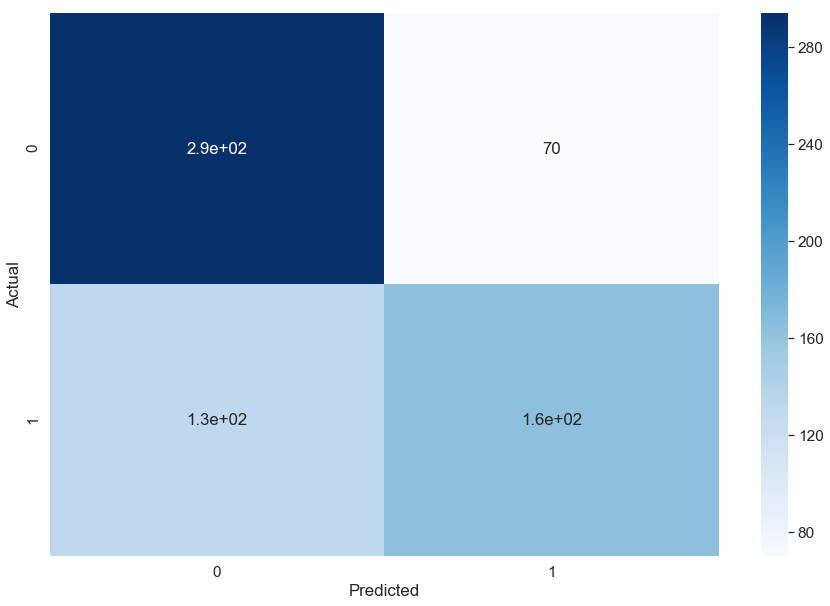

In [42]:
cm=confusion_matrix(valid_set_wrist.classes, predicted_class_indices)
plt.figure(figsize = (15,10))
sn.heatmap(cm, annot=True,cmap="Blues") 

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

From the confusion matrix above we can see that we accurately classify 294 negative/normal (0) X-rays as well as 164 positive/abnormal (1) X-rays. We misclassify 70 negative(0) X rays as abnormal, and 131 abnormal X-rays as normal.

In [43]:
cohen_kappa_score(predicted_class_indices,valid_set_wrist.classes)

0.37089351273563176

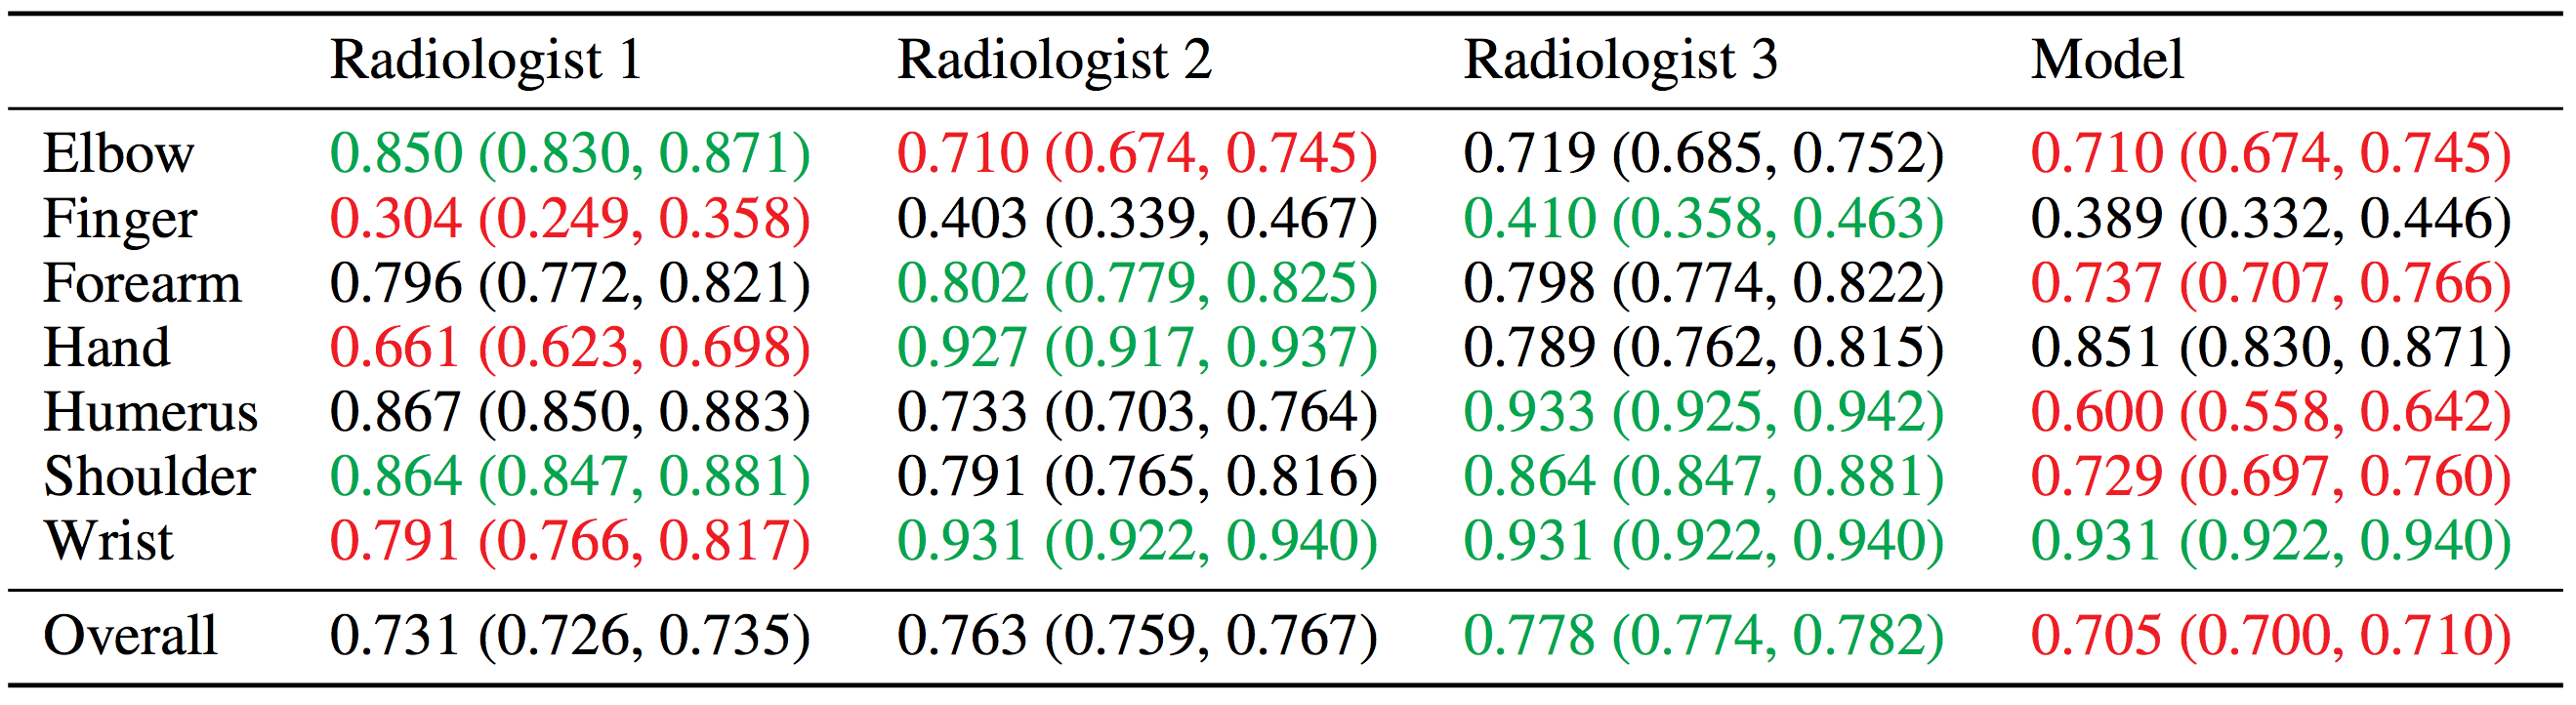

We compare our cohen kappa score to those from the MURA study as well as our experienced radiologist. This statistic is used as it takes into account random chance when classifying and it compares the accuracy of a model to that of a random model. The statistic ranges from values of -1 to 1 with values < 0 as indicating no agreement and 0–0.20 as slight, 0.21–0.40 as fair, 0.41–0.60 as moderate, 0.61–0.80 as substantial, and 0.81–1 as almost perfect agreement (https://en.wikipedia.org/wiki/Cohen%27s_kappa)


We got a score of 0.371 for our wrist model compared to a 0.931 to the MURA study model. This suggests that we have fair agreement and overall and that our model is not nearly complex or robust enough to accurately classify wrist images. 



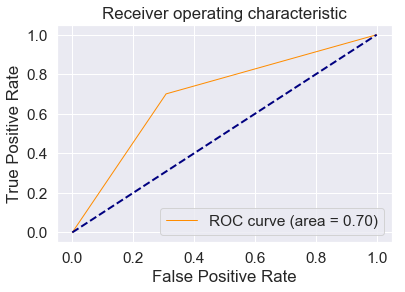

In [53]:
fpr, tpr, thresholds = roc_curve(predicted_class_indices, valid_set_wrist.classes)
roc_auc = auc(fpr, tpr)
lw=2
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

For the ROC graph above we can see that we have an AOC of 0.70 which means our model is capable of distiguishing between the abnormal and normal classes 70% of the time

#### Pre-built model

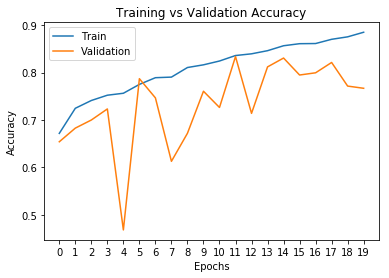

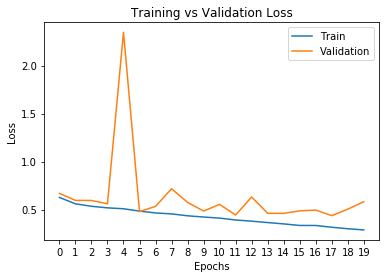

In [12]:
plt.figure(0)
plt.plot(hist_wrist2.history['acc'],)
plt.plot(hist_wrist2.history['val_acc'])
plt.xticks(np.arange(0, 20, 1))

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend(['Train','Validation'])
 
plt.figure(1)
plt.plot(hist_wrist2.history['loss'])
plt.plot(hist_wrist2.history['val_loss'])
plt.xticks(np.arange(0, 20, 1))

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend(['Train','Validation'])


 
plt.show()

Compared to our built model, the pre-built model achieves a greater validation accuracy (0.836) as well as have lower losses for both validation and training. This is not surprising as the prebuilt model is much more complex and robust with 121 layers compared to the built model's 7 layers. Additionally this model is not overfitting nearly as much as our built model. 

In [15]:
#reset our validation to prevent order change
valid_set_wrist.reset()

#predictions on validation
Y_pred = classifier2.predict_generator(valid_set_wrist,659/16)
predicted_class_indices=[1 if x >= 0.5 else 0 for x in Y_pred]

In [16]:
print(confusion_matrix(valid_set_wrist.classes, predicted_class_indices))

[[318  46]
 [108 187]]


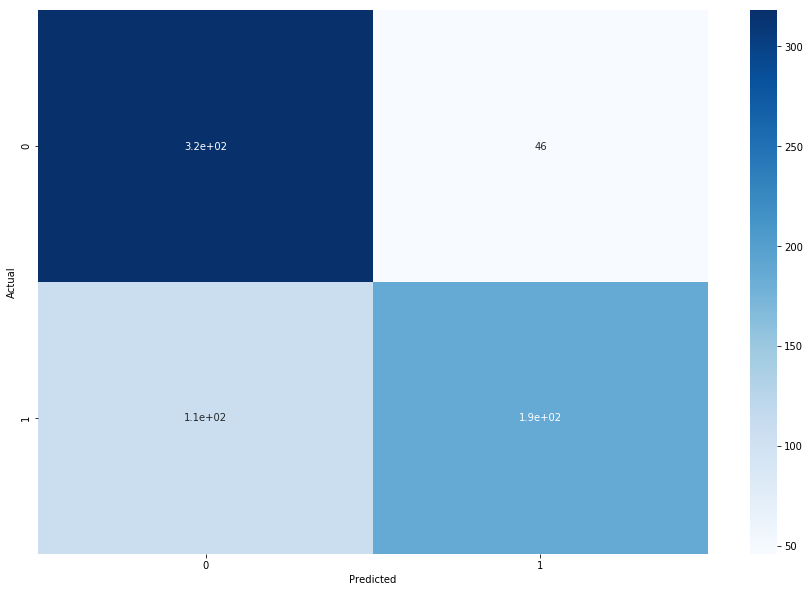

In [17]:
cm1=confusion_matrix(valid_set_wrist.classes, predicted_class_indices)
plt.figure(figsize = (15,10))
sn.heatmap(cm1, annot=True,cmap="Blues") 

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

From the confusion matrix above we can see that we accurately classify 318 negative/normal (0) X-rays as well as 187 positive/abnormal (1) X-rays. We misclassify 46 negative(0) X rays as abnormal, and 108 abnormal X-rays as normal.

We see a significant improvement on our false positives where in our built model we have 70 compared to the pre-built model with only 46.

In [18]:
cohen_kappa_score(predicted_class_indices,valid_set_wrist.classes)

0.5178400053211201

Our kappa score is also much better than our built model at 0.517, but is still significantly lower than the MURA study kappa score of 0.931.

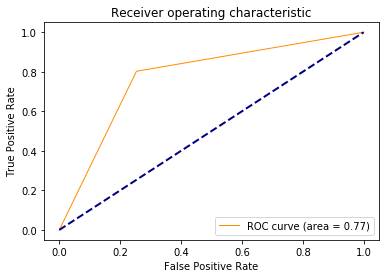

In [19]:
fpr, tpr, thresholds = roc_curve(predicted_class_indices, valid_set_wrist.classes)
roc_auc = auc(fpr, tpr)
lw=2
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

For the ROC graph above we can see that we have an AOC of 0.70 which means our model is capable of distiguishing between the abnormal and normal classes 77% of the time